In [1]:
import numpy as np
import os
import pandas as pd
import tools
from tqdm import tqdm
from matplotlib import pyplot as plt
import measures as ms
import seaborn as sns

import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from tempfile import TemporaryDirectory
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
# install Rtrack
rtrack = importr('Rtrack')
rstatix = importr('rstatix')

%load_ext autoreload
%autoreload 2

Warning message:
D-Bus service not found!

- If you are in a container environment, please consider adding the
  following to your configuration to silence this warning:

  options(bspm.sudo = TRUE)

- If you are in a desktop/server environment, please remove any 'bspm'
  installation from the user library and force a new system
  installation as follows:

  $ sudo Rscript --vanilla -e 'install.packages("bspm", repos="https://cran.r-project.org")' 


## Params

In [2]:
path_exp = "/home/jovyan/data/PNN.A-CMWMRawData/"
path_probe_trials = "PNN.A-C.MWM.probe/"
path_train_trials = ["PNN.A-C.MWM.REV.Train/",]

fname_genotypes = "MWMGenotypes.xlsx"

#radius platform in cm
r_platform = 6
# correct the estimated radius of the maze by a small percentage
r_maze_corr = 1.03

## Load metadata

In [3]:
# metadata of each recording
df_info_probe = tools.load_finfo_probe(path_exp+path_probe_trials)
df_info_probe['day'] = "probe"
df_info_train = tools.load_finfo_train(path_exp+path_train_trials[0])

df_info = pd.concat([df_info_probe, df_info_train])

# genotype data for each individual
def handle_values(val):
    if isinstance(val, str) and '*' in val:
        return val.replace('*', '')  # Replace '*' with an empty string
    return val
df_genotypes = pd.read_excel(path_exp+fname_genotypes, converters={'Subj': handle_values}, usecols=[0, 1, 2])
df_genotypes.set_index('Subj', inplace=True)

# merge both
df_info = pd.merge(df_info, df_genotypes[['sex', 'Geno']], left_on='animal_id', right_index=True, how='left')
df_info.reset_index(drop=True, inplace=True)

### Extract old platform location based on probe trial from initial learning.
The data does not explicitly state the location of the old platform during reversal learning.
Therefore we take the position of the non-existing platform of the probe trial.

In [15]:
idx_hid_probe = (
    (df_info['phase']=='HID') &
    (df_info['trial'] == 'Probe'))
df_info_hid_prob = df_info[idx_hid_probe][['animal_id', 'platform_pos']]
df_info_hid_prob.rename(columns={'platform_pos': 'xy_pltfrm_old'}, inplace=True)
df_info = df_info.merge(df_info_hid_prob, on='animal_id', how='left')

# for correctnes
df_info.loc[idx_hid_probe, 'xy_pltfrm_old'] = np.nan

### Estimate box boundaries based on trajectory (preferred for now)

In [7]:
plot = False

# points to plot
ls_pts = ['platform_pos', 'Q1', 'Q2', 'Q3', 'Q4',]

gp_pts = df_info.groupby(ls_pts)
for i, gp_i in tqdm(gp_pts):  
    ls_xy = []
    for j, row_j in gp_i.iterrows():
        # load recording
        path_j = row_j['relative_path']
        rec = tools.load_recording(path_j)
        # extract positions
        xy = np.hstack([np.array(rec['X center']), np.array(rec['Y center'])])
        ls_xy.append(xy)
    xy_all = np.vstack(ls_xy)

    # estimate center and radius based on max/min in x and y.
    center_x, center_y, radius = tools.detect_circle_boundaries(xy_all[:, 0], xy_all[:, 1])

    # apply correction factor
    radius = radius * r_maze_corr
    
    # store in dataframe
    df_info.loc[gp_i.index, 'center_x'] = center_x
    df_info.loc[gp_i.index, 'center_y'] = center_y
    df_info.loc[gp_i.index, 'radius'] = radius

    if plot:
        # Create a scatter plot
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.scatter(xy_all[:, 0], xy_all[:, 1], s=1)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(i)
    
        # plot cirlce
        circle_wall = plt.Circle((center_x, center_y), radius, color='red', fill=False)
        ax.add_patch(circle_wall)
    
        # plot platform
        circle_pltfrm = plt.Circle(i[0], r_platform, color='red', fill=False)
        ax.add_patch(circle_pltfrm)
    
        # plot quadrant points
        for j in range(1,5):
            circle_pltfrm = plt.Circle(i[j], 1, color='orange', fill=True)
            ax.add_patch(circle_pltfrm)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(i)
        plt.legend()
        plt.grid(True)
        plt.show()


100%|███████████████████████████████████████████████████████████████████| 25/25 [03:02<00:00,  7.31s/it]


## Classify Strategy

In [8]:
fname_res = 'data/strategy/df_res.pckl'
compute=False

In [9]:
if compute:
    ls_res = []
    for i, row_i in tqdm(df_info.iterrows()):
        
        # load recording
        path_i = row_i['relative_path']
        rec = tools.load_recording(path_i)
        # extract positions
        xy = np.hstack([np.array(rec['X center']), np.array(rec['Y center'])])
        # extract trial time
        t_trial = np.array(rec['Trial time']).flatten()
        # get recording time
        t_rec = np.array(rec['Recording time']).flatten()

        # center coordinates
        xy_center = np.array([
            row_i['center_x'],
            row_i['center_y']])
        xy -= xy_center

        ## exclude nan values
        #xy, t = tls.exclude_nan_values(xy, t)

        ## interpolate xy values
        #xy, t = tls.interpolate_xy_values(xy, t, dt)

        # get current platform location
        xy_pltfrm = np.array(row_i['platform_pos'])
        
        # get old platform location
        xy_pltfrm_old = np.array(row_i['xy_pltfrm_old'])

        # transform arena and path info for rtrack
        # arena
        s_arena = (
            'time.units = s\n' +
            'type = mwm\n' +
            'trial.length = 60\n'+
            'arena.bounds = circle 0.0 0.0 ' + str(row_i['radius'])+'\n'+
            'goal = circle '+str(xy_pltfrm[0]) + ' ' + str(xy_pltfrm[1]) + ' ' + str(r_platform) + '\n')
        if np.all(~pd.isna(xy_pltfrm_old)):
            s_arena += 'old.goal = circle '+str(xy_pltfrm_old[0]) + ' ' + str(xy_pltfrm_old[1]) + ' ' + str(r_platform)

        # path
        df_tmp = pd.DataFrame({
            'Time': t_rec,
            'X': xy[:, 0],
            'Y': xy[:, 1]})

        # create temporary directory 
        with TemporaryDirectory() as temp_dir:
            #temp_dir = mkdtemp()
            # store and read arena
            fname_arena = temp_dir+'/arena.txt'
            with open(fname_arena, 'w') as f:
                f.write(s_arena)

            # read arena
            arena = rtrack.read_arena(fname_arena)

            # store path
            fname_path = temp_dir+'/path.csv'
            df_tmp.to_csv(
                fname_path,
                sep=',',
                #header=False,
                index=False)


            dct_args = {'track.format': 'raw.csv'}
            # load path
            path = rtrack.read_path(
                fname_path,
                arena,
                **dct_args)

            metrics = rtrack.calculate_metrics(path, arena)

        # define strategy
        strategy = rtrack.call_strategy(metrics)

        # convert to pandas dataframe
        dct_strat = {x: v for x, v in strategy.items()}
        with localconverter(ro.default_converter + pandas2ri.converter):
            df_strat = ro.conversion.rpy2py(dct_strat['calls'])
        assert len(df_strat) == 1

        res = {
            'strategy_idx': int(df_strat['strategy'].iloc[0]),
            'strategy_name': df_strat['name'].iloc[0],
            'strategy_confidence': df_strat['confidence'].iloc[0]}
        # get also confidences for all other strategies
        for i in range(1, 10):
            res[str(i) + '_conf'] = df_strat[str(i)].iloc[0]
        ls_res.append(res)

    df_res = pd.DataFrame(ls_res)
    df_res.to_pickle(fname_res)

else:
    df_res = pd.read_pickle(fname_res)
df_info = df_info.join(df_res)

## Plot

### Summary plot per strategy across all available trials

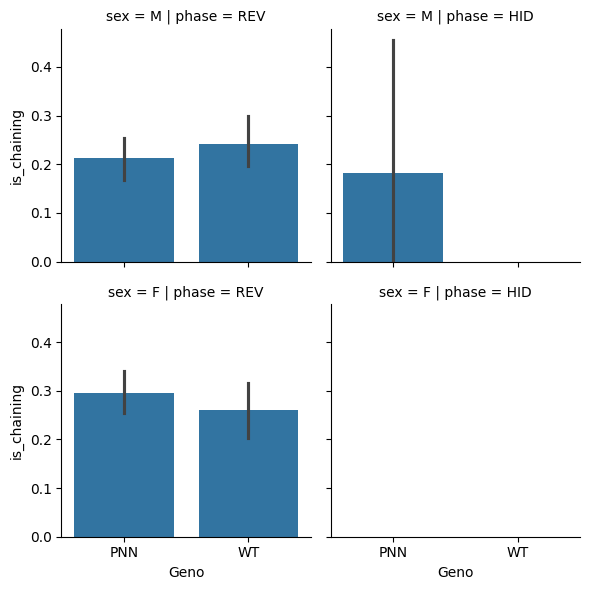

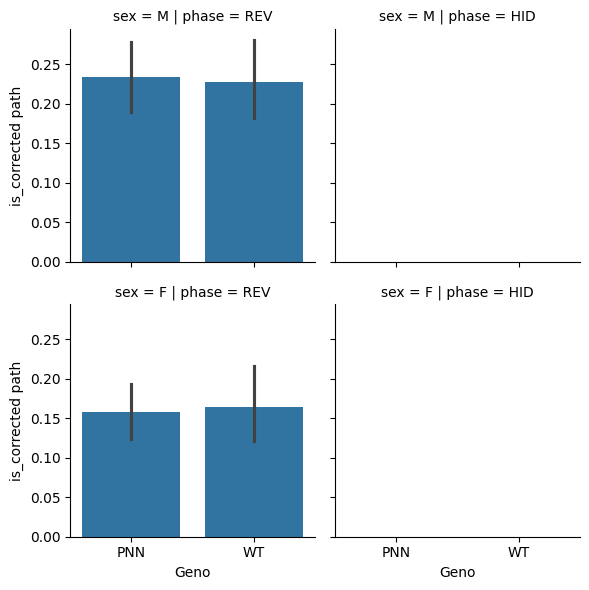

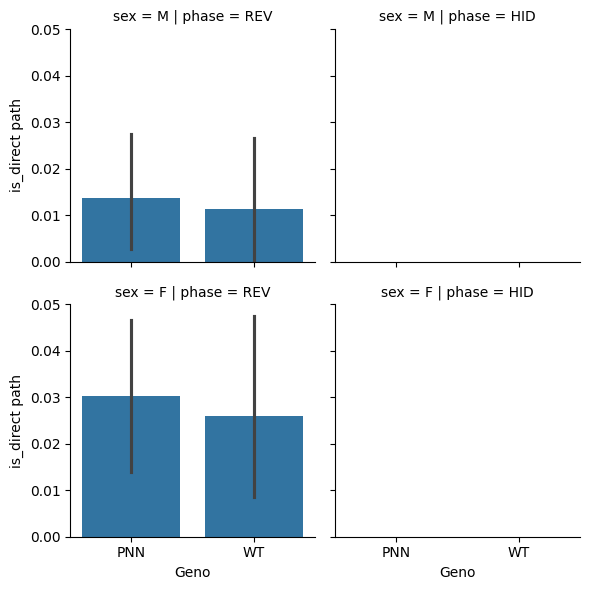

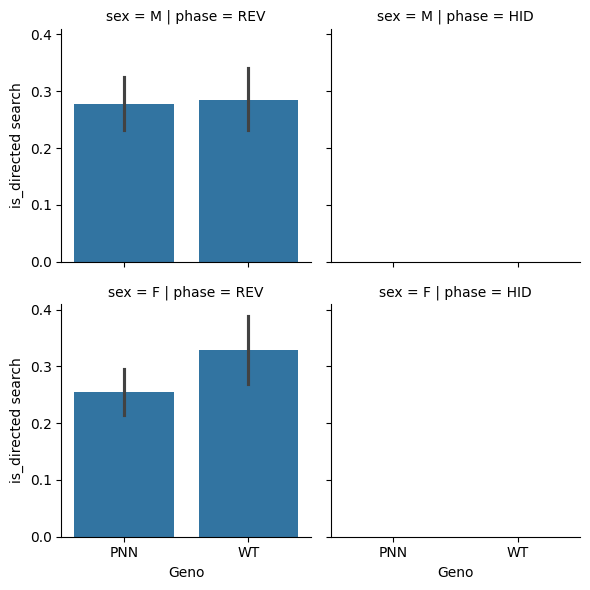

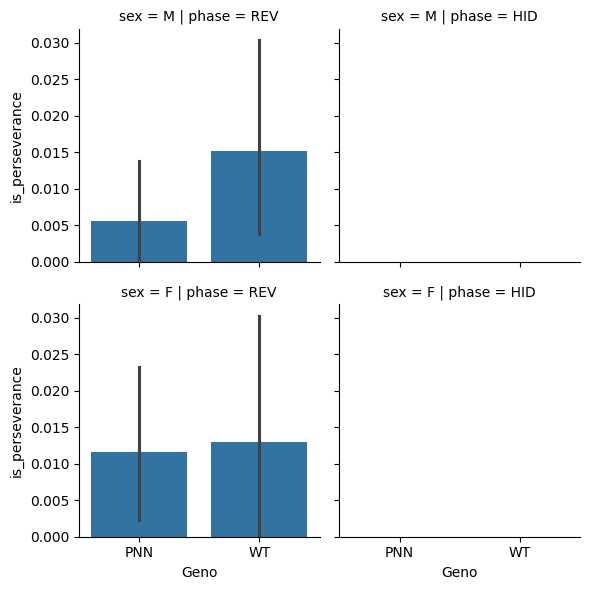

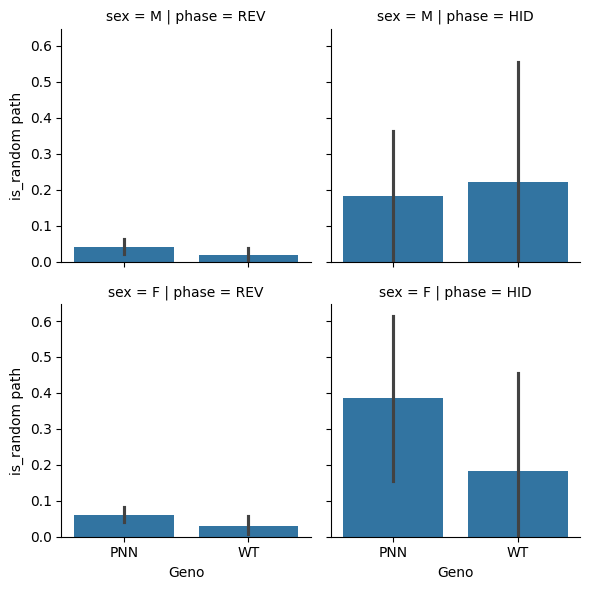

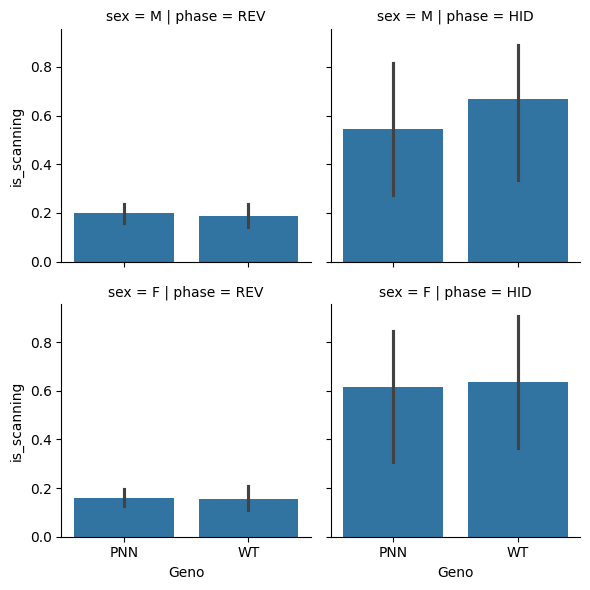

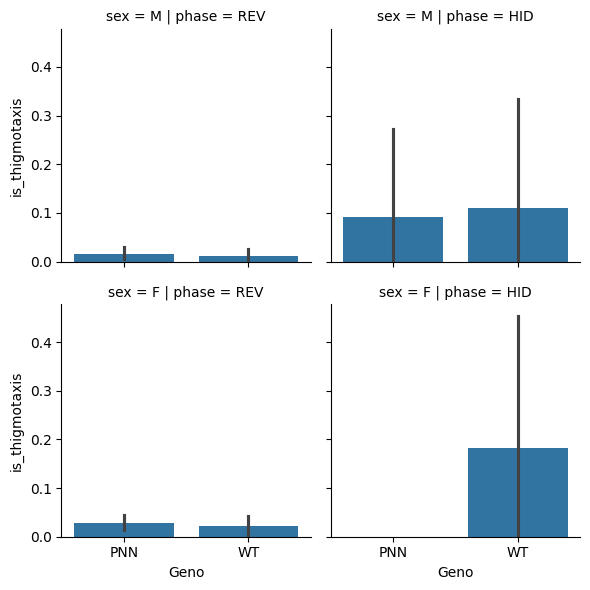

In [10]:
for strat_i in np.unique(df_info['strategy_name']):
    df_info['is_'+strat_i] = df_info['strategy_name']==sttrainingrat_i

for strat_i in np.unique(df_info['strategy_name']):
    
    # Create a FacetGrid with 'phase' as the column variable and 'sex' as the row variable
    g = sns.FacetGrid(data=df_info, col="phase", row="sex")
    
    # Map a bar plot of trial duration to each grid item
    g.map(sns.barplot, "Geno", 'is_'+strat_i, order=['PNN', 'WT'])

## Plot strategies per trial

In [12]:
# limit data to only train
df_train = df_info[df_info['day']!='probe']

In [13]:
# define color of each strategy
dct_strat = {
    'thigmotaxis': "#24868EFF",
    'circling': "#365D8DFF",
    'random path': "#365D8DFF",
    'scanning': "#404688FF",
    'chaining': "#5DC863FF",
    'directed search': "#8FD744FF",
    'corrected search': "#C7E020FF",
    'direct path': "#FDE725FF",
    'perseverance': "#440154FF",
}

dct_treat = {
    'PNN': 'Cre+',
    'WT': 'Cre-'}
# Define non-spatial and spatial
strat_group = {
    'non-spatial':[
         'scanning',
         'random path',
         'circling',
         'thigmotaxis'   
    ],
    'spatial': [
         'perseverance',
         'direct path',
         'corrected search',
         'directed search',
         'chaining']
}

In [14]:
# Calculate fraction of each strategy per day and treatment
grp_var = ('day', 'trial')
grp_day_treatment = df_train.groupby([grp_var, 'Geno', 'sex'])

res = []
for grp_name, grp_dat in grp_day_treatment:
    ls_strat, cnt_strat = np.unique(
        grp_dat['strategy_name'], return_counts=True)
    # calculate fraction of each strategy
    frac_strat = cnt_strat/len(grp_dat)
    res_i = {n:v for n, v in zip(ls_strat, frac_strat)}
    res_i[grp_var] = grp_name[0]
    res_i['Geno'] = grp_name[1]
    res_i['sex'] = grp_name[2]
#    res_i['day'] = grp_dat['grp_day']
    res.append(res_i)
df_res = pd.DataFrame(res)

# resort df_res
grp_day_order = list(df_info[grp_var].unique())
df_res[grp_var] = df_res[grp_var].astype("category")
df_res[grp_var] = df_res[grp_var].cat.set_categories(grp_day_order)
df_res = df_res.sort_values([grp_var])

#df_res.columns = pd.CategoricalIndex(
#    df_res.columns.values, 
#    ordered=True, 
#    categories=list(dct_strat.keys())[::-1]+['day', 'Geno', 'sex'] )

df_res = df_res.sort_index(axis=1)

KeyError: ('day', 'trial')

In [94]:
# calculate width ratios for each subplot
n, c = np.unique(df_res['day'], return_counts=True)
#width_ratios = np.array(width_ratios)
width_ratios = c/np.sum(n)

In [95]:
width_ratios

array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.11111111])

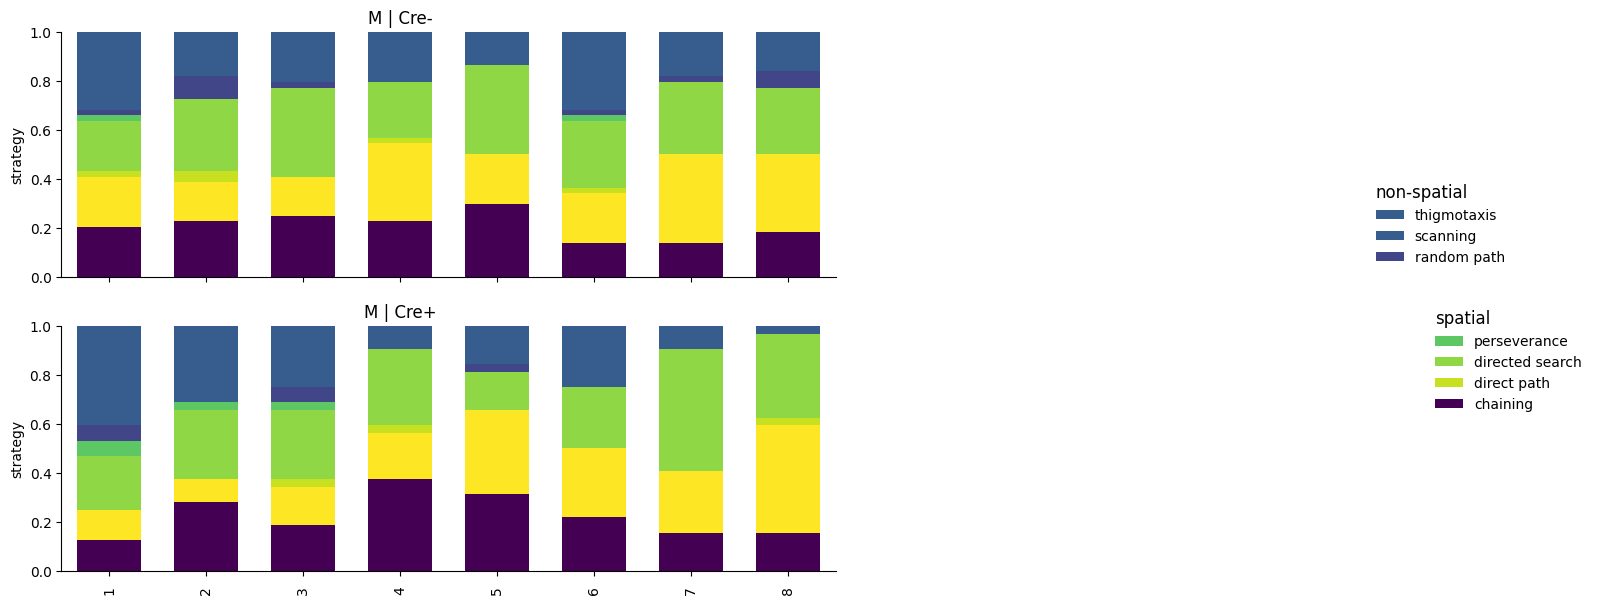

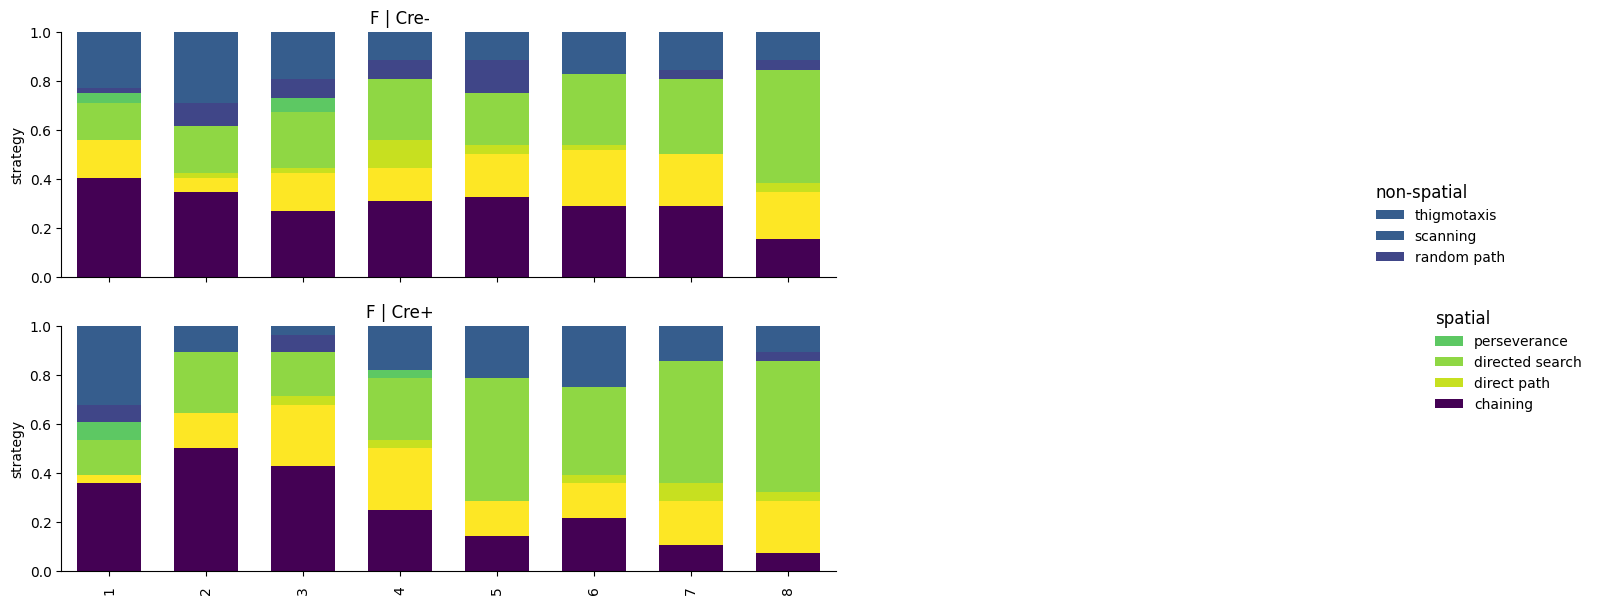

In [99]:


ls_pos = [
    [7.29 , 0.],
    [8, 0.6],
]
for i, sex_i in enumerate(['M', 'F']):

    fig, ax = plt.subplots(
        2,
        len(n),
        figsize=(10, 7),
        gridspec_kw={
            'width_ratios': width_ratios,
            'wspace': 0.01,
        }
    )
    
    for j, treat_j in enumerate(['PNN', 'WT']):
        for m, day_m in enumerate(n):
    
            df_jm = df_res[
                (df_res['sex']==sex_i) &
                (df_res['Geno']==treat_j) & 
                (df_res['day']==day_m)
            ]
            plt_jm = df_jm.plot(
                kind='bar',
                x=grp_var,
                stacked=True,
                title=treat_j,
                ylabel='strategy',
                ax=ax[j,m],
                width=1,
                color=list(dct_strat.values())[::-1],
            )
            plt_jm.get_legend().remove()
            ax[j,m].set_ylim(0, 1)
    
            ax[j,m].spines.right.set_visible(False)
            ax[j,m].spines.top.set_visible(False)
            ax[j,m].set_xticklabels('')    
    
            if m!=0:
                ax[j,m].spines.left.set_visible(False)
                ax[j,m].set_yticks([])
                ax[j,m].set_ylabel('')          
            
            ax[j,m].set_title('')
            ax[j,m].set_xlabel('')
    
            if j==1:
                ax[j,m].set_xlabel(df_jm['day'].iloc[0], rotation=90)
            
            if m==3:
                ax[j,m].set_title(sex_i + ' | ' +dct_treat[treat_j])
    
     
    
        handles, labels = ax[j, -1].get_legend_handles_labels()
    
        for m, (k, v) in enumerate(strat_group.items()):
            
            hndls_lbls_j = np.array(
                [[h, s] for h, s in zip(handles, labels) if s in v],
                dtype=object)
            hndls_j = hndls_lbls_j[:, 0]
            lbls_j = hndls_lbls_j[:, 1]
            
            if j==m:
                leg_j = ax[j, -1].legend(
                    reversed(hndls_j),
                    reversed(lbls_j),
                    title=k,
                    alignment='left',
                    title_fontsize='large')
                #leg_i._legend_box.align = "left"
                sns.move_legend(
                    ax[j, -1],
                    "lower center",
                    bbox_to_anchor=ls_pos[j],
                    frameon=False,    
                )


In [60]:
df_ij

,perseverance,direct path,directed search,chaining,scanning,random path,thigmotaxis,day,Geno,NaN
15,NaN,0.033333,0.433333,0.116667,0.066667,0.016667,NaN,8,WT,0.333333
